### Drought focus area from multiple datasets SPI3 & SPEI3

In [1]:
%who

Interactive namespace is empty.


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import matplotlib.pyplot as plt
%run -i drought_2017to2019/dataInfo_and_functions.py

In [36]:
import matplotlib.pyplot as plt

TINY_SIZE = 14
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 22

plt.rc('font', size=TINY_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=TINY_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#### 1. Based on mean SPI3/SPEI3 

In [4]:
data_dir_spi = '/g/data/w97/ad9701/drought_2017to2020/precip_data/SPI3_baseline_198101_202005/'
data_dir_spei = '/g/data/w97/ad9701/drought_2017to2020/PminusPET/SPEI3_baseline_198101_202005/'

time_slice = slice('2017-01-01', '2019-12-31')

filename = glob.glob(data_dir_spi + 'SPI3_agcd_monthly*.nc')
ds_agcd = xr.open_mfdataset(filename)
ds_agcd = ds_agcd.sel(time = time_slice)

filename = glob.glob(data_dir_spi + 'SPI3_mswep_monthly*.nc')[0]
ds_mswep = xr.open_dataset(filename)
ds_mswep = ds_mswep.sel(time = time_slice)

filename = glob.glob(data_dir_spi + 'SPI3_chirps_monthly*.nc')[0]
ds_chirps = xr.open_dataset(filename)
ds_chirps = ds_chirps.sel(time = time_slice)

filename = glob.glob(data_dir_spei + 'SPEI3_awra_monthly*.nc')
ds_awra = xr.open_mfdataset(filename)
ds_awra = ds_awra.sel(time = time_slice)

filename = glob.glob(data_dir_spei + 'SPEI3_gleam_monthly*.nc')[0]
ds_gleam = xr.open_dataset(filename)
ds_gleam = ds_gleam.sel(time = time_slice)

data_names = ['SPI3_AGCD', 'SPI3_MSWEP', 'SPI3_CHIRPS', 'SPEI3_AWRA', 'SPEI3_GLEAM']
data_list = [ds_agcd['SPI3'], ds_mswep['SPI3'], ds_chirps['SPI3'], ds_awra['SPEI3'], ds_gleam['SPEI3']]

In [27]:
# regridding to common resolution for averaging

import xesmf as xe
ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-10.125, -44.125, -0.25)),
        "lon": (["lon"], np.arange(112.125, 154.125, 0.25)),
    }
)

data_list_regrid = []

# use the same time dimension for all the datasets
time_dim = data_list[0].time.values

for da in data_list:
    da = da.chunk({'lat':-1, 'lon':-1})
    if da.values.shape[1:] == (136, 168):     # already at coarsest resolution
        da = da.assign_coords({'time': time_dim})
        data_list_regrid.append(da)
    else:
        regridder = xe.Regridder(da, ds_out, 'bilinear')
        da_reg = regridder(da)
        da_reg = da_reg.assign_coords({'time': time_dim})
        print(da_reg.time)
        data_list_regrid.append(da_reg)
        
da_regrid = xr.concat(data_list_regrid, dim = 'data').assign_coords({'data': data_names}).rename('SPI3/SPEI3')

gleam_maskfile = '/g/data/w97/ad9701/drought_2017to2020/PminusPET/gleam_land_mask.nc'
ds_mask = xr.open_dataset(gleam_maskfile)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:454: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


<xarray.DataArray 'time' (time: 36)>
array(['2017-01-16T00:00:00.000000000', '2017-02-14T12:00:00.000000000',
       '2017-03-16T00:00:00.000000000', '2017-04-15T12:00:00.000000000',
       '2017-05-16T00:00:00.000000000', '2017-06-15T12:00:00.000000000',
       '2017-07-16T00:00:00.000000000', '2017-08-16T00:00:00.000000000',
       '2017-09-15T12:00:00.000000000', '2017-10-16T00:00:00.000000000',
       '2017-11-15T12:00:00.000000000', '2017-12-16T00:00:00.000000000',
       '2018-01-16T00:00:00.000000000', '2018-02-14T12:00:00.000000000',
       '2018-03-16T00:00:00.000000000', '2018-04-15T12:00:00.000000000',
       '2018-05-16T00:00:00.000000000', '2018-06-15T12:00:00.000000000',
       '2018-07-16T00:00:00.000000000', '2018-08-16T00:00:00.000000000',
       '2018-09-15T12:00:00.000000000', '2018-10-16T00:00:00.000000000',
       '2018-11-15T12:00:00.000000000', '2018-12-16T00:00:00.000000000',
       '2019-01-16T00:00:00.000000000', '2019-02-14T12:00:00.000000000',
       '2019-0

In [28]:
da_regrid

<xarray.DataArray 'SPI3/SPEI3' (data: 5, time: 36, lat: 136, lon: 168)>
dask.array<concatenate, shape=(5, 36, 136, 168), dtype=float64, chunksize=(1, 36, 136, 168), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2017-01-16 2017-02-14T12:00:00 ... 2019-12-16
  * lon      (lon) float64 112.1 112.4 112.6 112.9 ... 153.1 153.4 153.6 153.9
  * lat      (lat) float64 -10.12 -10.38 -10.62 -10.88 ... -43.38 -43.62 -43.88
  * data     (data) <U11 'SPI3_AGCD' 'SPI3_MSWEP' ... 'SPEI3_AWRA' 'SPEI3_GLEAM'
Attributes:
    regrid_method:  bilinear

In [29]:
da_mean = da_regrid.mean('data')
mon_sel = [6, 7, 8, 9]

dry_thresh = -1  # values below this threshold are atleast moderately dry (WMO document)
time_slice = slice('2017-01-01', '2019-12-31')

da_index_dry = da_mean.where(da_mean <= dry_thresh).sel(time = time_slice).count('time').rename('count months')
da_index_dry = da_index_dry*ds_mask['land_mask']
da_index_dry_byyear = da_mean.where(da_mean <= dry_thresh).sel(time = time_slice).groupby('time.year').count('time').rename('count months')
da_index_dry_byyear = da_index_dry_byyear*ds_mask['land_mask']

da_index_dry_JJAS = da_mean.where(da_mean <= dry_thresh).sel(time = time_slice).sel(time=da_mean.time.dt.month.isin(mon_sel)).count('time').rename('count months')
da_index_dry_JJAS = da_index_dry_JJAS*ds_mask['land_mask']
da_index_dry_JJAS_byyear = da_mean.where(da_mean <= dry_thresh).sel(time = time_slice).sel(time=da_mean.time.dt.month.isin(mon_sel)).groupby('time.year').count('time').rename('count months')
da_index_dry_JJAS_byyear = da_index_dry_JJAS_byyear*ds_mask['land_mask']

In [30]:
da_index_dry_JJAS.load()
da_index_dry_JJAS_byyear.load()

<xarray.DataArray (year: 3, lat: 136, lon: 168)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lon      (lon) float64 112.1 112.4 112.6 112.9 ... 153.1 153.4 153.6 153.9
  * lat      (lat) float64 -10.12 -10.38 -10.62 -10.88 ... -43.38 -43.62 -43.88
  * year     (year) int64 2017 2018 2019

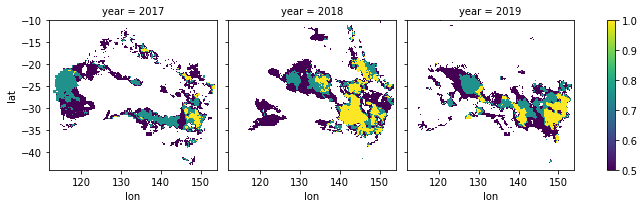

In [46]:
(da_index_dry_JJAS_byyear/4).where(da_index_dry_JJAS_byyear>=2).plot(col = "year")

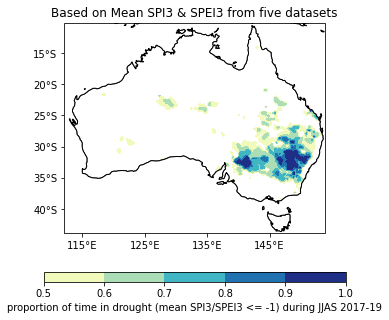

In [53]:
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

total_months = 4*3
ds = da_index_dry_JJAS/total_months

fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(6,4.5)) #width, height

xlim = [ds['lon'].values.min(), ds['lon'].values.max()]
ylim = [ds['lat'].values.min(), ds['lat'].values.max()]

xticks = np.arange(115,155,10)  #lon
yticks = np.arange(-40,-10,5)   #lat

cs=axs.contourf(ds['lon'],ds['lat'],ds,levels,
                      transform = ccrs.PlateCarree(),
                      cmap="YlGnBu") #,extend='both')   #cmap options: coolwarm,

# Draw the coastines for each subplot
axs.coastlines()
axs.add_feature(cfeature.OCEAN, zorder=2, edgecolor='k', facecolor='w')

axs.set_title('Based on Mean SPI3 & SPEI3 from five datasets')

# Longitude labels
axs.set_xticks(xticks, crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
axs.xaxis.set_major_formatter(lon_formatter)
axs.set_xlim(xlim)

# Latitude labels
axs.set_yticks(yticks, crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
axs.yaxis.set_major_formatter(lat_formatter)
axs.set_ylim(ylim)

# Delete the unwanted axes
# for i in [5]:
#     fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.3, top=0.95, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.08)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.03])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal', label='proportion of time in drought (mean SPI3/SPEI3 <= -1) during JJAS 2017-19')

plt.savefig(out_dir + 'mean_spi3_spei3_prop_dry_JJAS_2017to19_gt_pt5.png')

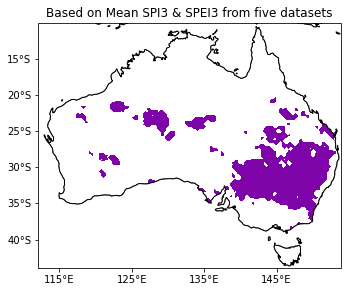

In [41]:
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
# levels = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
levels = [0, 1, 2]

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

total_months = 4*3
ds = da_index_dry_JJAS/total_months
ds = xr.where(ds >= 0.5, 1, np.nan)

fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(6,4.5)) #width, height

xlim = [ds['lon'].values.min(), ds['lon'].values.max()]
ylim = [ds['lat'].values.min(), ds['lat'].values.max()]

xticks = np.arange(115,155,10)  #lon
yticks = np.arange(-40,-10,5)   #lat

cs=axs.contourf(ds['lon'],ds['lat'],ds,levels,
                      transform = ccrs.PlateCarree(),
                      cmap="plasma") #"YlGnBu") #,extend='both')   #cmap options: coolwarm,

# Draw the coastines for each subplot
axs.coastlines()
axs.add_feature(cfeature.OCEAN, zorder=2, edgecolor='k', facecolor='w')

axs.set_title('Based on Mean SPI3 & SPEI3 from five datasets')

# Longitude labels
axs.set_xticks(xticks, crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
axs.xaxis.set_major_formatter(lon_formatter)
axs.set_xlim(xlim)

# Latitude labels
axs.set_yticks(yticks, crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
axs.yaxis.set_major_formatter(lat_formatter)
axs.set_ylim(ylim)

# Delete the unwanted axes
# for i in [5]:
#     fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
# fig.subplots_adjust(bottom=0.3, top=0.95, left=0.05, right=0.95,
#                     wspace=0.1, hspace=0.08)

# # Add a colorbar axis at the bottom of the graph
# cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.03])

# # Draw the colorbar
# cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal', label='proportion of time in drought (mean SPI3/SPEI3 <= -1) > 0.5')

plt.savefig(out_dir + 'focus_reg_prop_dry_JJAS_2017to19.png')

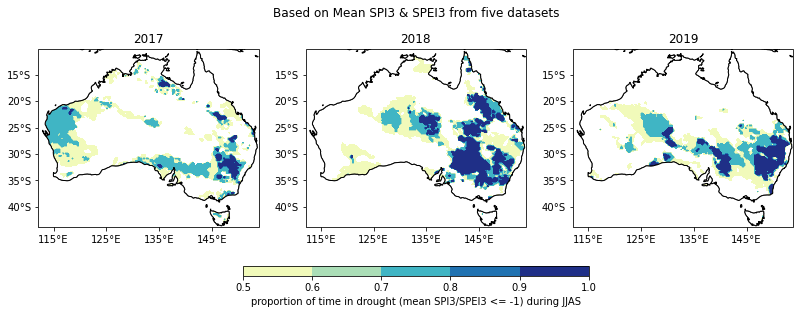

In [54]:
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = [0.49999999, 0.6, 0.7, 0.8, 0.9, 1]

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

total_months = 4
dry_prop = da_index_dry_JJAS_byyear/total_months
ds_list = [dry_prop[0,:,:], dry_prop[1,:,:], dry_prop[2,:,:]]
years = dry_prop.year.values
ds = ds_list[0]

fig, axs = plt.subplots(nrows=1,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(12,4.5)) #width, height

xlim = [ds['lon'].values.min(), ds['lon'].values.max()]
ylim = [ds['lat'].values.min(), ds['lat'].values.max()]

xticks = np.arange(115,155,10)  #lon
yticks = np.arange(-40,-10,5)   #lat

for i in np.arange(len(ds_list)):
    cs=axs[i].contourf(ds_list[i]['lon'],ds_list[i]['lat'],ds_list[i],levels,
                          transform = ccrs.PlateCarree(),
                          cmap="YlGnBu") #,extend='both')   #cmap options: coolwarm,

    # Draw the coastines for each subplot
    axs[i].coastlines()
    axs[i].add_feature(cfeature.OCEAN, zorder=2, edgecolor='k', facecolor='w')

    axs[i].set_title(years[i])

    # Longitude labels
    axs[i].set_xticks(xticks, crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)
    axs[i].set_xlim(xlim)

    # Latitude labels
    axs[i].set_yticks(yticks, crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    axs[i].set_ylim(ylim)

# Delete the unwanted axes
# for i in [5]:
#     fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.3, top=0.85, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.08)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.03])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal', label='proportion of time in drought (mean SPI3/SPEI3 <= -1) during JJAS')

plt.suptitle('Based on Mean SPI3 & SPEI3 from five datasets')
plt.savefig(out_dir + 'mean_spi3_spei3_prop_dry_JJAS_2017to19_gt_pt5_byyear.png')

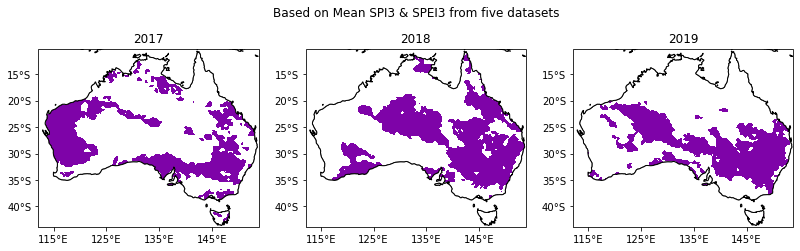

In [56]:
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = [0, 1, 2]

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

total_months = 4
dry_prop = da_index_dry_JJAS_byyear/total_months
dry_prop = xr.where(dry_prop >= 0.5, 1, np.nan)

ds_list = [dry_prop[0,:,:], dry_prop[1,:,:], dry_prop[2,:,:]]
years = dry_prop.year.values
ds = ds_list[0]
fig, axs = plt.subplots(nrows=1,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(12,4.5)) #width, height

xlim = [ds['lon'].values.min(), ds['lon'].values.max()]
ylim = [ds['lat'].values.min(), ds['lat'].values.max()]

xticks = np.arange(115,155,10)  #lon
yticks = np.arange(-40,-10,5)   #lat

for i in np.arange(len(ds_list)):
    cs=axs[i].contourf(ds_list[i]['lon'],ds_list[i]['lat'],ds_list[i],levels,
                          transform = ccrs.PlateCarree(),
                          cmap="plasma") #,extend='both')   #cmap options: coolwarm,

    # Draw the coastines for each subplot
    axs[i].coastlines()
    axs[i].add_feature(cfeature.OCEAN, zorder=2, edgecolor='k', facecolor='w')

    axs[i].set_title(years[i])

    # Longitude labels
    axs[i].set_xticks(xticks, crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)
    axs[i].set_xlim(xlim)

    # Latitude labels
    axs[i].set_yticks(yticks, crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    axs[i].set_ylim(ylim)

# Delete the unwanted axes
# for i in [5]:
#     fig.delaxes(axs[i])

# # Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.3, top=0.85, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.08)

# # Add a colorbar axis at the bottom of the graph
# cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.03])

# # Draw the colorbar
# cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal', label='proportion of time in drought (mean SPI3/SPEI3 <= -1) during JJAS')

plt.suptitle('Based on Mean SPI3 & SPEI3 from five datasets')
plt.savefig(out_dir + 'focus_reg_prop_dry_JJAS_2017to19_byyear.png')

#### 2. Based on mean proportion of time in drought identified from five datasets

In [1]:
%who

Interactive namespace is empty.


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import matplotlib.pyplot as plt
import pickle

%run -i drought_2017to2019/dataInfo_and_functions.py

In [3]:
# loading the saved pickle objects containing the proportion of time that is dry (SPI3/SPEI3 <= -1)

data_dir_spi = '/g/data/w97/ad9701/drought_2017to2020/precip_data/SPI3_baseline_198101_202005/'
data_dir_spei = '/g/data/w97/ad9701/drought_2017to2020/PminusPET/SPEI3_baseline_198101_202005/'

time_slice = slice('2017-01-01', '2019-12-31')

in_file = data_dir_spei + 'spei_list_dry_JJAS.pickle'
with open(in_file, 'rb') as handle:
    spei_list_dry_JJAS = pickle.load(handle)
    
in_file = data_dir_spei + 'spei_list_dry_JJAS_byyear.pickle'
with open(in_file, 'rb') as handle:
    spei_list_dry_JJAS_byyear = pickle.load(handle)
    
in_file = data_dir_spi + 'spi_list_dry_JJAS.pickle'
with open(in_file, 'rb') as handle:
    spi_list_dry_JJAS = pickle.load(handle)
    
in_file = data_dir_spi + 'spi_list_dry_JJAS_byyear.pickle'
with open(in_file, 'rb') as handle:
    spi_list_dry_JJAS_byyear = pickle.load(handle)
    
data_names = ['SPI3_AGCD', 'SPI3_MSWEP', 'SPI3_CHIRPS', 'SPEI3_AWRA', 'SPEI3_GLEAM']

In [4]:
spi_spei_list = spi_list_dry_JJAS
spi_spei_list.extend(spei_list_dry_JJAS)

spi_spei_list_byyear = spi_list_dry_JJAS_byyear
spi_spei_list_byyear.extend(spei_list_dry_JJAS_byyear)

In [5]:
# regridding to common resolution for averaging

import xesmf as xe
def regrid_all_from_list(da_list, lat = np.arange(-10.125, -44.125, -0.25), lon = np.arange(112.125, 154.125, 0.25)):
    ds_out = xr.Dataset(
        {
            "lat": (["lat"], lat),
            "lon": (["lon"], lon),
        }
    )
    shape_tuple = (len(lat), len(lon))    
    
    da_list_regrid = []  
    for da in da_list:
        da = da.chunk({'lat':-1, 'lon':-1})
        if (da.values.shape[1:] == shape_tuple) | (da.values.shape == shape_tuple):     # assumed that same shape means data is already at the desired resolution
            da_list_regrid.append(da)
        else:
            regridder = xe.Regridder(da, ds_out, 'bilinear')
            da_reg = regridder(da)
            da_list_regrid.append(da_reg)        
    return da_list_regrid

In [6]:
spi_spei_list_regrid = regrid_all_from_list(spi_spei_list)
spi_spei_list_byyear_regrid = regrid_all_from_list(spi_spei_list_byyear)

da_prop = xr.concat(spi_spei_list_regrid, dim = "data").assign_coords({'data': data_names})
da_prop_byyear = xr.concat(spi_spei_list_byyear_regrid, dim = "data").assign_coords({'data': data_names})

da_prop_mean = da_prop.mean('data')
da_prop_byyear_mean = da_prop_byyear.mean('data')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


In [26]:
# save

out_dir = '/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/'

da_mean = da_prop_mean.rename('count_months').drop('time').assign_attrs({'description': 'Mean count of JJAS months with SPI3/SPEI3 < -1. Based on 5 datasets'})
da_mean_byyear = da_prop_byyear_mean.rename('count_months').drop('time').assign_attrs({'description': 'Mean count of JJAS months with SPI3/SPEI3 < -1. Based on 5 datasets'})

with open(out_dir + 'mean_count_dry_months_JJAS.pickle', 'wb') as handle:
    pickle.dump(da_mean, handle)
with open(out_dir + 'mean_count_dry_months_JJAS_byyear.pickle', 'wb') as handle:
    pickle.dump(da_mean_byyear, handle)

In [ ]:
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = [0, 1, 2]

total_months = 4
dry_prop = da_index_dry_JJAS_byyear/total_months
dry_prop = xr.where(dry_prop >= 0.5, 1, np.nan)

ds_list = [dry_prop[0,:,:], dry_prop[1,:,:], dry_prop[2,:,:]]
years = dry_prop.year.values

subplot_title = years

out_figname = 'focus_reg_prop_dry_JJAS_2017to19_byyear.png'
cbar_label = 'proportion of time in drought (mean SPI3/SPEI3 <= -1) during JJAS'

main_title = 'Based on Mean SPI3 & SPEI3 from five datasets'
cbar_label = 'proportion of time in drought (mean SPI3/SPEI3 <= -1) during JJAS 2017-19'
out_figname = 'mean_spi3_spei3_prop_dry_JJAS_2017to19_gt_pt5.png'

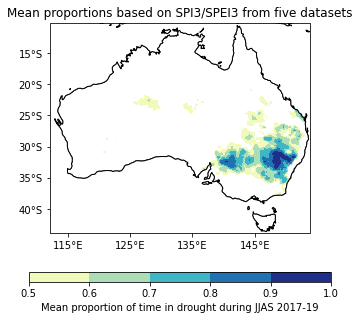

In [9]:
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = np.linspace(0.5, 1, 6)
main_title = 'Mean proportions based on SPI3/SPEI3 from five datasets'
out_figname = 'mean_prop_dry_JJAS_2017to19_gt_pt5.png'
cbar_label = 'Mean proportion of time in drought during JJAS 2017-19'

total_months = 4*3
draw_spatial_plot(ds = da_prop_mean/total_months, cmap = 'YlGnBu', levels = levels, main_title = main_title,
                  out_dir = out_dir, out_figname = out_figname, add_cbar = True, cbar_label = cbar_label)

In [10]:
contour_list = [da_prop_byyear_mean.sel(year=i)/4 for i in da_prop_byyear_mean.year.values]
contour_list

[<xarray.DataArray (lat: 136, lon: 168)>
 dask.array<truediv, shape=(136, 168), dtype=float64, chunksize=(136, 168), chunktype=numpy.ndarray>
 Coordinates:
     time     datetime64[ns] ...
     year     int64 2017
   * lon      (lon) float64 112.1 112.4 112.6 112.9 ... 153.1 153.4 153.6 153.9
   * lat      (lat) float64 -10.12 -10.38 -10.62 -10.88 ... -43.38 -43.62 -43.88,
 <xarray.DataArray (lat: 136, lon: 168)>
 dask.array<truediv, shape=(136, 168), dtype=float64, chunksize=(136, 168), chunktype=numpy.ndarray>
 Coordinates:
     time     datetime64[ns] ...
     year     int64 2018
   * lon      (lon) float64 112.1 112.4 112.6 112.9 ... 153.1 153.4 153.6 153.9
   * lat      (lat) float64 -10.12 -10.38 -10.62 -10.88 ... -43.38 -43.62 -43.88,
 <xarray.DataArray (lat: 136, lon: 168)>
 dask.array<truediv, shape=(136, 168), dtype=float64, chunksize=(136, 168), chunktype=numpy.ndarray>
 Coordinates:
     time     datetime64[ns] ...
     year     int64 2019
   * lon      (lon) float64 112.1 

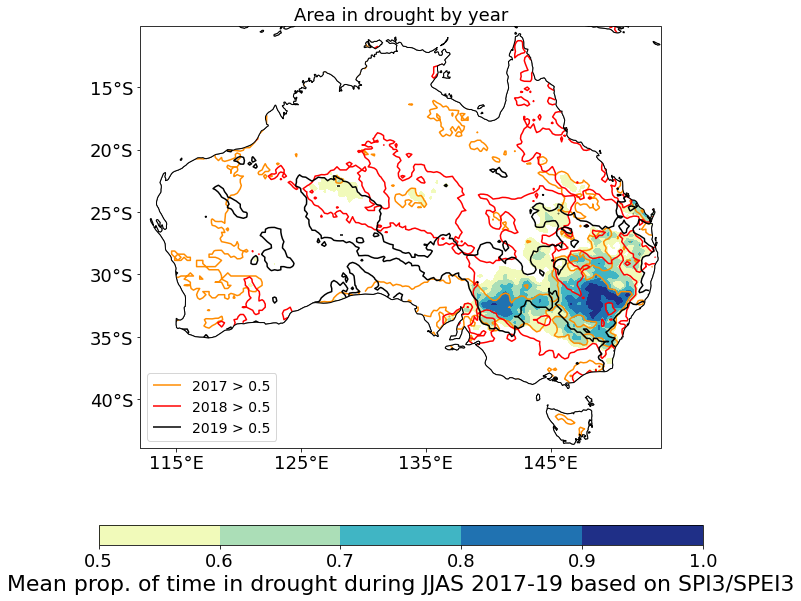

In [46]:
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = np.linspace(0.5, 1, 6)
main_title = 'Area in drought by year'
out_figname = 'contour_droughtReg_byyear_gt0.5.png'
cbar_label = 'Mean prop. of time in drought during JJAS 2017-19 based on SPI3/SPEI3'

col_sel = ['darkorange', 'red', 'black']

total_months = 4*3

clev = 0.5
contour_labels = [str(x) + ' > 0.5' for x in da_prop_byyear_mean.year.values]
draw_spatial_plot_addcontours(ds = da_prop_mean/total_months, cmap = 'YlGnBu', levels = levels, main_title = main_title,
                  out_dir = out_dir, out_figname = out_figname, add_cbar = True, cbar_label = cbar_label, 
                  ds_contour_list=contour_list, contour_level=[clev], contour_labels=contour_labels, contour_colors=col_sel)

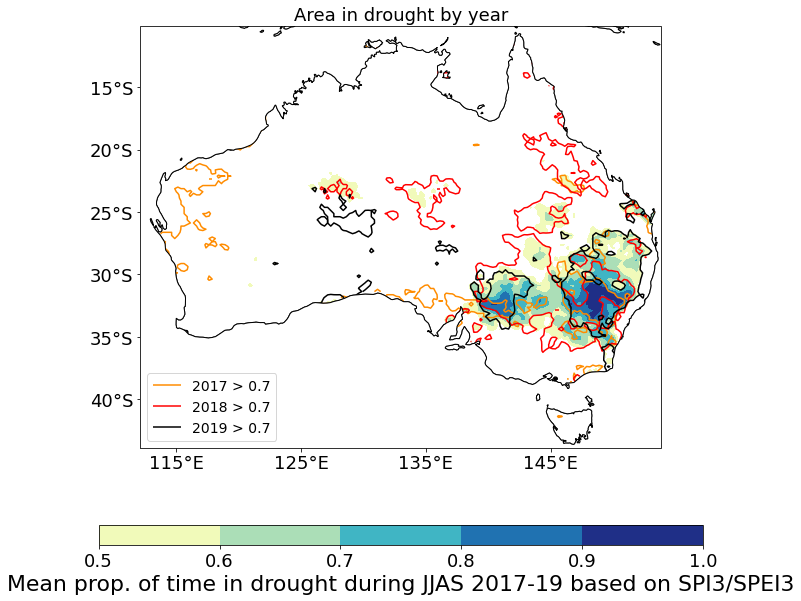

In [63]:
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = np.linspace(0.5, 1, 6)
main_title = 'Area in drought by year'
#out_figname = 'contour_droughtReg_byyear_gt0.7.png'
out_figname = 'test2_contour.png'
cbar_label = 'Mean prop. of time in drought during JJAS 2017-19 based on SPI3/SPEI3'

col_sel = ['darkorange', 'red', 'black']

total_months = 4*3

clev = 0.7
contour_labels = [str(x) + ' > ' + str(clev) for x in da_prop_byyear_mean.year.values]
draw_spatial_plot_addcontours(ds = da_prop_mean/total_months, cmap = 'YlGnBu', levels = levels, main_title = main_title,
                  out_dir = out_dir, out_figname = out_figname, add_cbar = True, cbar_label = cbar_label, 
                  ds_contour_list=contour_list, contour_level=[clev], contour_labels=contour_labels, contour_colors=col_sel)

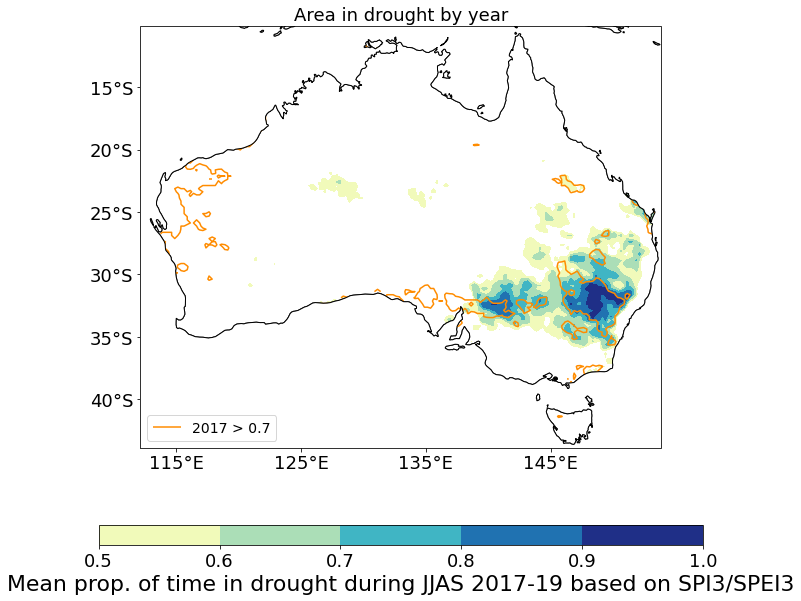

In [62]:
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = np.linspace(0.5, 1, 6)
main_title = 'Area in drought by year'
#out_figname = 'contour_droughtReg_byyear_gt0.7.png'
out_figname = 'test_contour.png'
cbar_label = 'Mean prop. of time in drought during JJAS 2017-19 based on SPI3/SPEI3'

col_sel = ['darkorange', 'red', 'black']

total_months = 4*3

clev = 0.7
contour_labels = [str(x) + ' > ' + str(clev) for x in da_prop_byyear_mean.year.values]
draw_spatial_plot_addcontours(ds = da_prop_mean/total_months, cmap = 'YlGnBu', levels = levels, main_title = main_title,
                  out_dir = out_dir, out_figname = out_figname, add_cbar = True, cbar_label = cbar_label, 
                  ds_contour_list=[contour_list[0]], contour_level=[clev], contour_labels=contour_labels, contour_colors=col_sel)

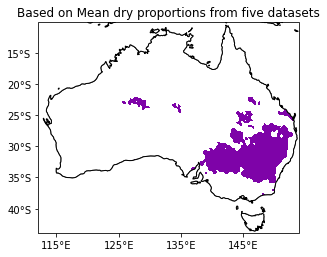

In [12]:
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = [0, 1, 2]
main_title = 'Based on Mean dry proportions from five datasets'
out_figname = 'focus_reg_basedOn_mean_prop_JJAS_2017to19.png'

total_months = 4*3
da_focusReg = xr.where(da_prop_mean/total_months >=0.5, 1, np.nan)
draw_spatial_plot(ds = da_focusReg, cmap = 'plasma', levels = levels, main_title = main_title,
                  out_dir = out_dir, out_figname = out_figname, add_cbar = False) #, cbar_label = cbar_label)

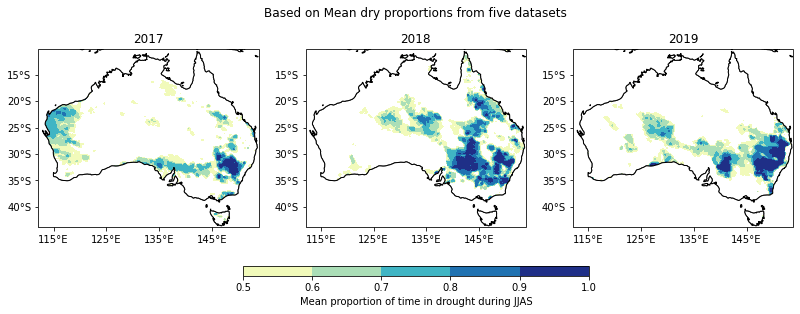

In [22]:
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = [0.49999999, 0.6, 0.7, 0.8, 0.9, 1] #np.linspace(0.5, 1, 6)
main_title = 'Based on Mean dry proportions from five datasets'
out_figname = 'mean_prop_dry_JJAS_2017to19_gt_pt5_byyear.png'
cbar_label = 'Mean proportion of time in drought during JJAS'

total_months = 4

da_byyear = da_prop_byyear_mean/total_months
years = da_byyear.year.values
ds_list = [da_byyear[0,:,:], da_byyear[1,:,:], da_byyear[2,:,:]] 
draw_spatial_plot_3panels(ds_list = ds_list, cmap = 'YlGnBu', levels = levels, subplot_title = years, main_title = main_title, 
                              out_dir = out_dir, out_figname = out_figname, add_cbar = True, cbar_label = cbar_label)

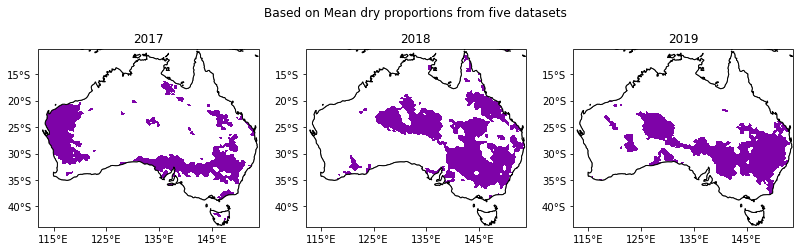

In [23]:
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = [0, 1, 2]
main_title = 'Based on Mean dry proportions from five datasets'
out_figname = 'focus_reg_basedOn_mean_prop_JJAS_2017to19_byyear.png'

total_months = 4

da_byyear = da_prop_byyear_mean/total_months
years = da_byyear.year.values
da_focusReg = xr.where(da_byyear >=0.5, 1, np.nan)
ds_list = [da_focusReg[0,:,:], da_focusReg[1,:,:], da_focusReg[2,:,:]] 

draw_spatial_plot_3panels(ds_list = ds_list, cmap = 'plasma', levels = levels, subplot_title = years, main_title = main_title, 
                              out_dir = out_dir, out_figname = out_figname, add_cbar = False) #, cbar_label = cbar_label)

### 2a. Based on mean proportion of time in drought identified from five datasets  
Consider all months (not only JJAS)

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import matplotlib.pyplot as plt
import pickle

%run -i drought_2017to2019/dataInfo_and_functions.py

In [2]:
import matplotlib.pyplot as plt

TINY_SIZE = 14
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 22

plt.rc('font', size=TINY_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=TINY_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# loading the saved pickle objects containing the proportion of time that is dry (SPI3/SPEI3 <= -1)

data_dir_spi = '/g/data/w97/ad9701/drought_2017to2020/precip_data/SPI3_baseline_198101_202005/'
data_dir_spei = '/g/data/w97/ad9701/drought_2017to2020/PminusPET/SPEI3_baseline_198101_202005/'

time_slice = slice('2017-01-01', '2019-12-31')

in_file = data_dir_spei + 'spei_list_dry.pickle'
with open(in_file, 'rb') as handle:
    spei_list_dry = pickle.load(handle)
    
in_file = data_dir_spei + 'spei_list_dry_byyear.pickle'
with open(in_file, 'rb') as handle:
    spei_list_dry_byyear = pickle.load(handle)
    
in_file = data_dir_spi + 'spi_list_dry.pickle'
with open(in_file, 'rb') as handle:
    spi_list_dry = pickle.load(handle)
    
in_file = data_dir_spi + 'spi_list_dry_byyear.pickle'
with open(in_file, 'rb') as handle:
    spi_list_dry_byyear = pickle.load(handle)
    
data_names = ['SPI3_AGCD', 'SPI3_MSWEP', 'SPI3_CHIRPS', 'SPEI3_AWRA', 'SPEI3_GLEAM']

In [4]:
# save SPI and SPEI in a list

spi_spei_list = spi_list_dry
spi_spei_list.extend(spei_list_dry)

spi_spei_list_byyear = spi_list_dry_byyear
spi_spei_list_byyear.extend(spei_list_dry_byyear)

In [5]:
spi_spei_list_regrid = regrid_all_from_list(spi_spei_list)
spi_spei_list_byyear_regrid = regrid_all_from_list(spi_spei_list_byyear)

da_prop = xr.concat(spi_spei_list_regrid, dim = "data").assign_coords({'data': data_names})
da_prop_byyear = xr.concat(spi_spei_list_byyear_regrid, dim = "data").assign_coords({'data': data_names})

da_prop_mean = da_prop.mean('data')
da_prop_byyear_mean = da_prop_byyear.mean('data')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


In [6]:
da_prop_mean

<xarray.DataArray (lat: 136, lon: 168)>
dask.array<mean_agg-aggregate, shape=(136, 168), dtype=float64, chunksize=(136, 168), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] ...
  * lon      (lon) float64 112.1 112.4 112.6 112.9 ... 153.1 153.4 153.6 153.9
  * lat      (lat) float64 -10.12 -10.38 -10.62 -10.88 ... -43.38 -43.62 -43.88

In [7]:
# save

out_dir = '/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/'

da_mean = da_prop_mean.rename('count_months').drop('time').assign_attrs({'description': 'Mean count of all 2017-19 months with SPI3/SPEI3 < -1. Based on 5 datasets'})
da_mean_byyear = da_prop_byyear_mean.rename('count_months').drop('time').assign_attrs({'description': 'Mean count of all 2017-19 months with SPI3/SPEI3 < -1. Based on 5 datasets'})

with open(out_dir + 'mean_count_dry_months.pickle', 'wb') as handle:
    pickle.dump(da_mean, handle)
with open(out_dir + 'mean_count_dry_months_byyear.pickle', 'wb') as handle:
    pickle.dump(da_mean_byyear, handle)

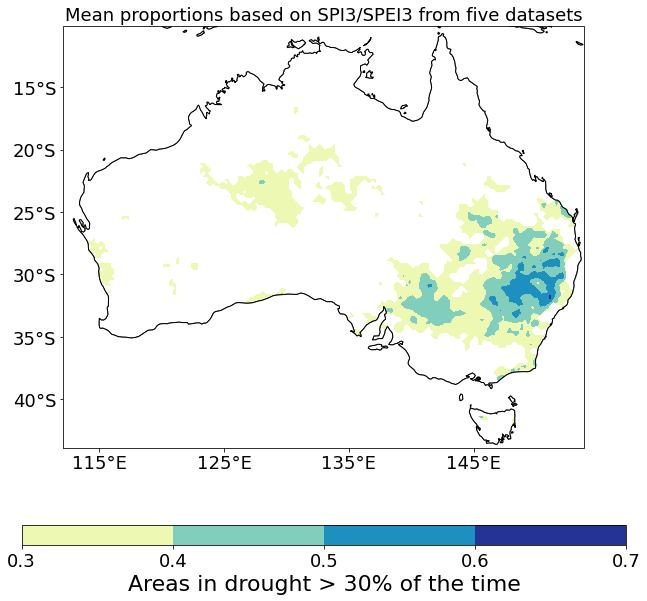

In [31]:
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = np.linspace(0.3, 0.7, 5)
main_title = 'Mean proportions based on SPI3/SPEI3 from five datasets'
out_figname = 'mean_prop_dry_allmon_2017to19_gt_pt0.3.png'

total_months = 12*3
prop_thresh = 0.3
cbar_label = 'Areas in drought > 30% of the time'

da_plot = da_prop_mean/total_months
da_plot = da_plot.where(da_plot > prop_thresh)
draw_spatial_plot(ds = da_plot, cmap = 'YlGnBu', levels = levels, main_title = main_title,
                  out_dir = out_dir, out_figname = out_figname, add_cbar = True, cbar_label = cbar_label)

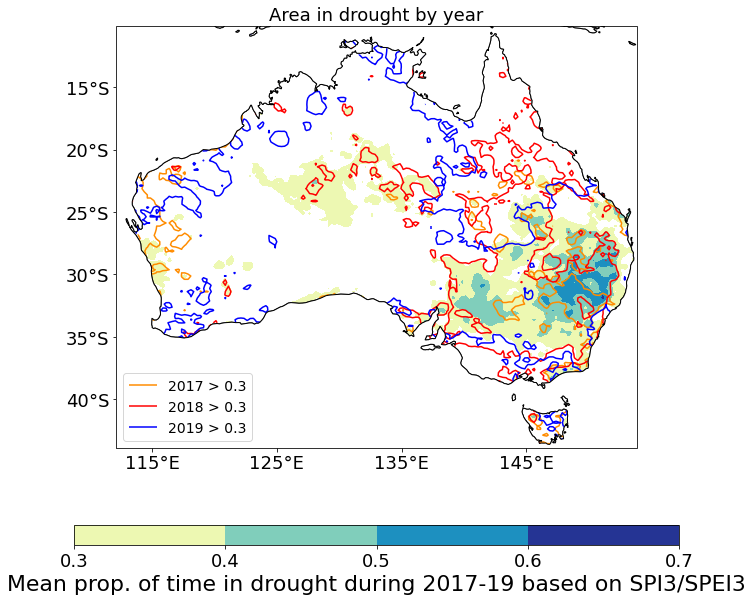

In [42]:
contour_list = [da_prop_byyear_mean.sel(year=i)/12 for i in da_prop_byyear_mean.year.values]

out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = np.linspace(0.3, 0.7, 5)
main_title = 'Area in drought by year'
out_figname = 'contour_droughtReg_byyear_allmon_gt0.3.png'
cbar_label = 'Mean prop. of time in drought during 2017-19 based on SPI3/SPEI3'

col_sel = ['darkorange', 'red', 'blue']

total_months = 12*3

clev = 0.3
contour_labels = [str(x) + ' > ' + str(clev) for x in da_prop_byyear_mean.year.values]
draw_spatial_plot_addcontours(ds = da_prop_mean/total_months, cmap = 'YlGnBu', levels = levels, main_title = main_title,
                  out_dir = out_dir, out_figname = out_figname, add_cbar = True, cbar_label = cbar_label, 
                  ds_contour_list=contour_list, contour_level=[clev], contour_labels=contour_labels, contour_colors=col_sel)

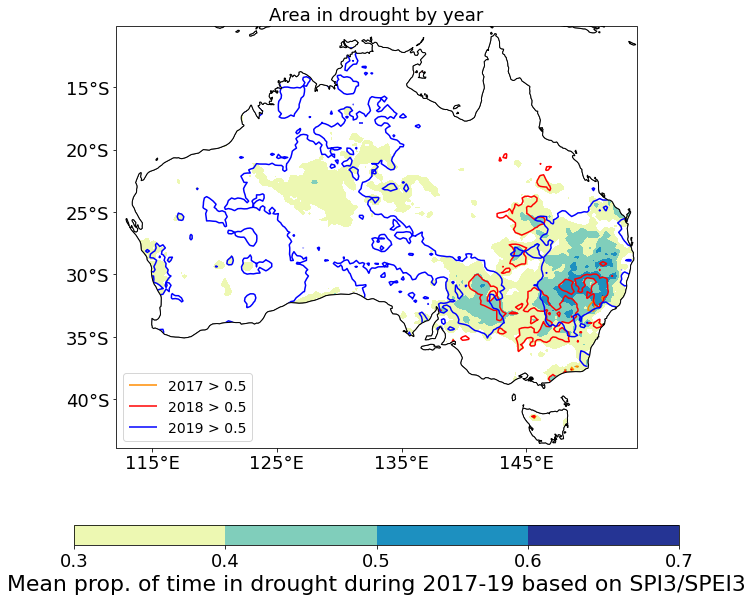

In [43]:
contour_list = [da_prop_byyear_mean.sel(year=i)/12 for i in da_prop_byyear_mean.year.values]

out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = np.linspace(0.3, 0.7, 5)
main_title = 'Area in drought by year'
out_figname = 'contour_droughtReg_byyear_allmon_gt0.5.png'
cbar_label = 'Mean prop. of time in drought during 2017-19 based on SPI3/SPEI3'

col_sel = ['darkorange', 'red', 'blue']

total_months = 12*3

clev = 0.5
contour_labels = [str(x) + ' > ' + str(clev) for x in da_prop_byyear_mean.year.values]
draw_spatial_plot_addcontours(ds = da_prop_mean/total_months, cmap = 'YlGnBu', levels = levels, main_title = main_title,
                  out_dir = out_dir, out_figname = out_figname, add_cbar = True, cbar_label = cbar_label, 
                  ds_contour_list=contour_list, contour_level=[clev], contour_labels=contour_labels, contour_colors=col_sel)

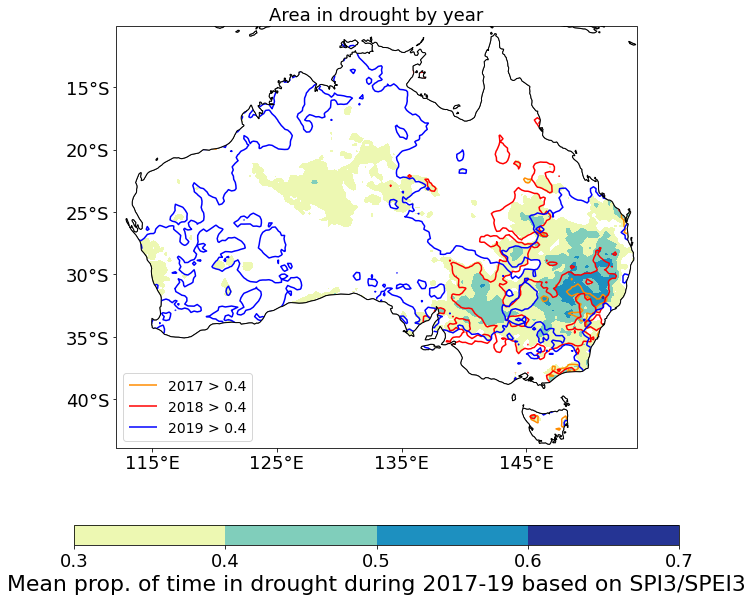

In [44]:
contour_list = [da_prop_byyear_mean.sel(year=i)/12 for i in da_prop_byyear_mean.year.values]

out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = np.linspace(0.3, 0.7, 5)
main_title = 'Area in drought by year'
out_figname = 'contour_droughtReg_byyear_allmon_gt0.4.png'
cbar_label = 'Mean prop. of time in drought during 2017-19 based on SPI3/SPEI3'

col_sel = ['darkorange', 'red', 'blue']

total_months = 12*3

clev = 0.4
contour_labels = [str(x) + ' > ' + str(clev) for x in da_prop_byyear_mean.year.values]
draw_spatial_plot_addcontours(ds = da_prop_mean/total_months, cmap = 'YlGnBu', levels = levels, main_title = main_title,
                  out_dir = out_dir, out_figname = out_figname, add_cbar = True, cbar_label = cbar_label, 
                  ds_contour_list=contour_list, contour_level=[clev], contour_labels=contour_labels, contour_colors=col_sel)

### Based on the 10th/15th/20th percentile threshold

In [1]:
%who

Interactive namespace is empty.


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import matplotlib.pyplot as plt
import pickle

%run -i drought_2017to2019/dataInfo_and_functions.py

In [3]:
perc = 15

data_dir_P = '/g/data/w97/ad9701/drought_2017to2020/precip_data/drght_' + str(perc) + 'th_perc_baseline_198101_202005/'
data_dir_PminusPET = '/g/data/w97/ad9701/drought_2017to2020/PminusPET/drght_' + str(perc) + 'th_perc_baseline_198101_202005/'

time_slice = slice('2017-01-01', '2019-12-31')
mon_sel = [6, 7, 8, 9]

data_names = ['AGCD', 'MSWEP', 'CHIRPS'] #, 'AWRA', 'GLEAM']
data_dir = dict(zip(data_names,
                    [data_dir_P, data_dir_P, data_dir_P])) #, data_dir_PminusPET, data_dir_PminusPET]))

# lists to store the count of the number of months during which the drought existed
data_list = []
data_list_byyear = []
data_names_lower = [d.lower() for d in data_names]
for d in data_names_lower:
    fname = alldata_dict[d]['mon_file'].split('.')[0] + '_lt_' + str(perc) + 'th_perc.nc'
    
    data_type = (data_dir[d.upper()].split('/')[-3]).split('_')[0]
    if data_type == 'precip':
        vname = alldata_dict[d]['varname']
    elif data_type == 'PminusPET':
        vname = 'PminusPET'
    
    in_file = data_dir[d.upper()] + fname
    ds = xr.open_dataset(in_file)
    da_temp = ds[vname].sel(time = time_slice)
    data_list.append(da_temp.sel(time=da_temp.time.dt.month.isin(mon_sel)).count('time'))
    data_list_byyear.append(da_temp.sel(time=da_temp.time.dt.month.isin(mon_sel)).groupby('time.year').count('time'))
    
data_list_regrid = regrid_all_from_list(data_list)
data_list_byyear_regrid = regrid_all_from_list(data_list_byyear)

da_prop = xr.concat(data_list_regrid, dim = "data").assign_coords({'data': data_names})
da_prop_byyear = xr.concat(data_list_byyear_regrid, dim = "data").assign_coords({'data': data_names})

da_prop_mean = da_prop[0:3, :, :].mean('data')
da_prop_byyear_mean = da_prop_byyear[0:3, :, :, :].mean('data')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


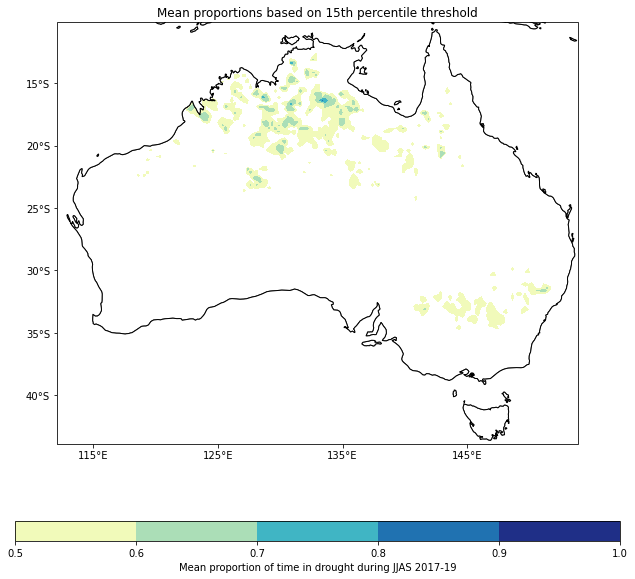

In [6]:
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = np.linspace(0.5, 1, 6)
main_title = 'Mean proportions based on ' + str(perc) + 'th percentile threshold'
out_figname = 'mean_' + str(perc) + 'th_perc_precip_prop_dry_JJAS_2017to19_gt_pt5_test.png'
cbar_label = 'Mean proportion of time in drought during JJAS 2017-19'

total_months = 4*3
draw_spatial_plot(ds = da_prop_mean/total_months, cmap = 'YlGnBu', levels = levels, main_title = main_title,
                  out_dir = out_dir, out_figname = out_figname, add_cbar = True, cbar_label = cbar_label)

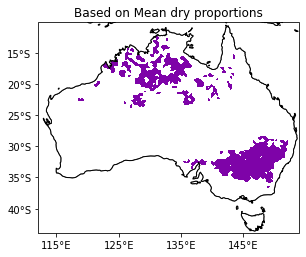

In [13]:
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = [0, 1, 2]
main_title = 'Based on Mean dry proportions'
out_figname = 'focus_reg_basedOn_' + str(perc) + 'th_perc_mean_prop_JJAS_2017to19.png'

total_months = 4*3
da_focusReg = xr.where(da_prop_mean/total_months >=0.5, 1, np.nan)
draw_spatial_plot(ds = da_focusReg, cmap = 'plasma', levels = levels, main_title = main_title,
                  out_dir = out_dir, out_figname = out_figname, add_cbar = False) #, cbar_label = cbar_label)

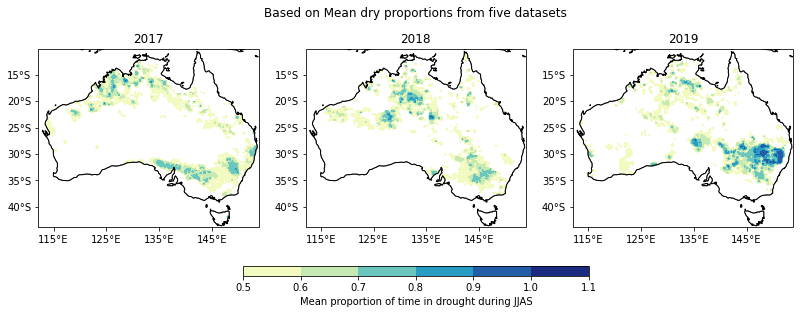

In [14]:
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = [0.49999999, 0.6, 0.7, 0.8, 0.9, 1, 1.1] #np.linspace(0.5, 1, 6)
main_title = 'Based on Mean dry proportions from five datasets'
out_figname = 'mean_prop_dry_precip_' + str(perc) + 'thp_JJAS_2017to19_gt_pt5_byyear.png'
cbar_label = 'Mean proportion of time in drought during JJAS'

total_months = 4

da_byyear = da_prop_byyear_mean/total_months
years = da_byyear.year.values
ds_list = [da_byyear[0,:,:], da_byyear[1,:,:], da_byyear[2,:,:]] 
draw_spatial_plot_3panels(ds_list = ds_list, cmap = 'YlGnBu', levels = levels, subplot_title = years, main_title = main_title, 
                              out_dir = out_dir, out_figname = out_figname, add_cbar = True, cbar_label = cbar_label)

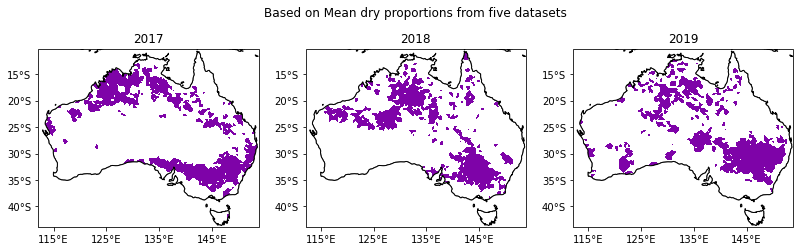

In [15]:
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = [0, 1, 2]
main_title = 'Based on Mean dry proportions from five datasets'
out_figname = 'focus_reg_basedOn_' + str(perc) + 'th_perc_mean_prop_JJAS_2017to19_byyear.png'

total_months = 4

da_byyear = da_prop_byyear_mean/total_months
years = da_byyear.year.values
da_focusReg = xr.where(da_byyear >=0.5, 1, np.nan)
ds_list = [da_focusReg[0,:,:], da_focusReg[1,:,:], da_focusReg[2,:,:]] 

draw_spatial_plot_3panels(ds_list = ds_list, cmap = 'plasma', levels = levels, subplot_title = years, main_title = main_title, 
                              out_dir = out_dir, out_figname = out_figname, add_cbar = False) #, cbar_label = cbar_label)

### Applying percentile thresholds on JJAS sum

In [2]:
%who

Interactive namespace is empty.


In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import matplotlib.pyplot as plt
import pickle

%run -i drought_2017to2019/dataInfo_and_functions.py

In [6]:
perc = 10

data_dir_P = '/g/data/w97/ad9701/drought_2017to2020/precip_data/drght_' + str(perc) + 'th_perc_baseline_198101_202005_JJAS/'
# data_dir_PminusPET = '/g/data/w97/ad9701/drought_2017to2020/PminusPET/drght_20th_perc_baseline_198101_202005/'

year_slice = slice(2017, 2019)

data_names = ['AGCD', 'MSWEP', 'CHIRPS'] #, 'AWRA', 'GLEAM']
data_dir = dict(zip(data_names,
                    [data_dir_P, data_dir_P, data_dir_P])) #, data_dir_PminusPET, data_dir_PminusPET]))

# lists to store the count of the number of months during which the drought existed
data_list = []
data_list_byyear = []
data_names_lower = [d.lower() for d in data_names]
for d in data_names_lower:
    
    fname = d + '_JJAS_precip_lt_' + str(perc) + 'th_perc.nc'
    
    data_type = (data_dir[d.upper()].split('/')[-3]).split('_')[0]
    if data_type == 'precip':
        vname = alldata_dict[d]['varname']
    elif data_type == 'PminusPET':
        vname = 'PminusPET'
    
    in_file = data_dir[d.upper()] + fname
    ds = xr.open_dataset(in_file)
    da_temp = ds[vname].sel(year = year_slice)
    data_list.append(da_temp)
    
data_list_regrid = regrid_all_from_list(data_list)
da_lt_xp = xr.concat(data_list_regrid, dim = "data").assign_coords({'data': data_names})

ds_mask = xr.open_dataset('/g/data/w97/ad9701/drought_2017to2020/PminusPET/gleam_land_mask.nc')
da_mask = ds_mask['land_mask']

da_lt_xp_mask = xr.where(~np.isnan(da_lt_xp), 1, np.nan)*da_mask

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


In [7]:
# save

out_dir = '/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/'

da_mean = da_lt_xp_mask.sum('year').mean('data').rename('count').drop('quantile').assign_attrs({'description': 'Mean count of 2017-19 JJAS season rain < ' + str(perc) + 'th percentile. Based on 3 precip datasets'})
da_byyear = da_lt_xp_mask.mean('data').rename('count').drop('quantile').assign_attrs({'description': 'JJAS season rain < ' + str(perc) + 'th percentile. Based on 3 precip datasets'})

with open(out_dir + 'JJASseas_rain_' + str(perc) + 'perc.pickle', 'wb') as handle:
    pickle.dump(da_mean, handle)
with open(out_dir + 'JJASseas_rain_byyear_' + str(perc) + 'perc.pickle', 'wb') as handle:
    pickle.dump(da_byyear, handle)

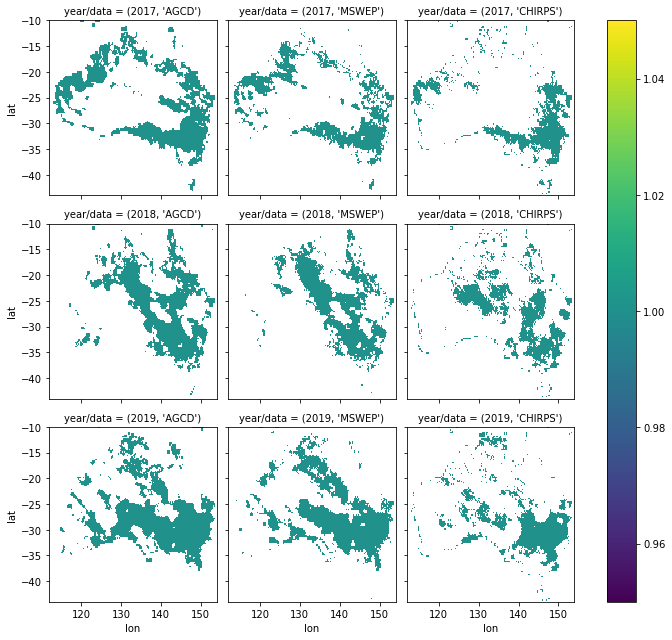

In [9]:
da_lt_xp_mask.stack({'year/data':['year', 'data']}).plot(col = 'year/data', col_wrap = 3)

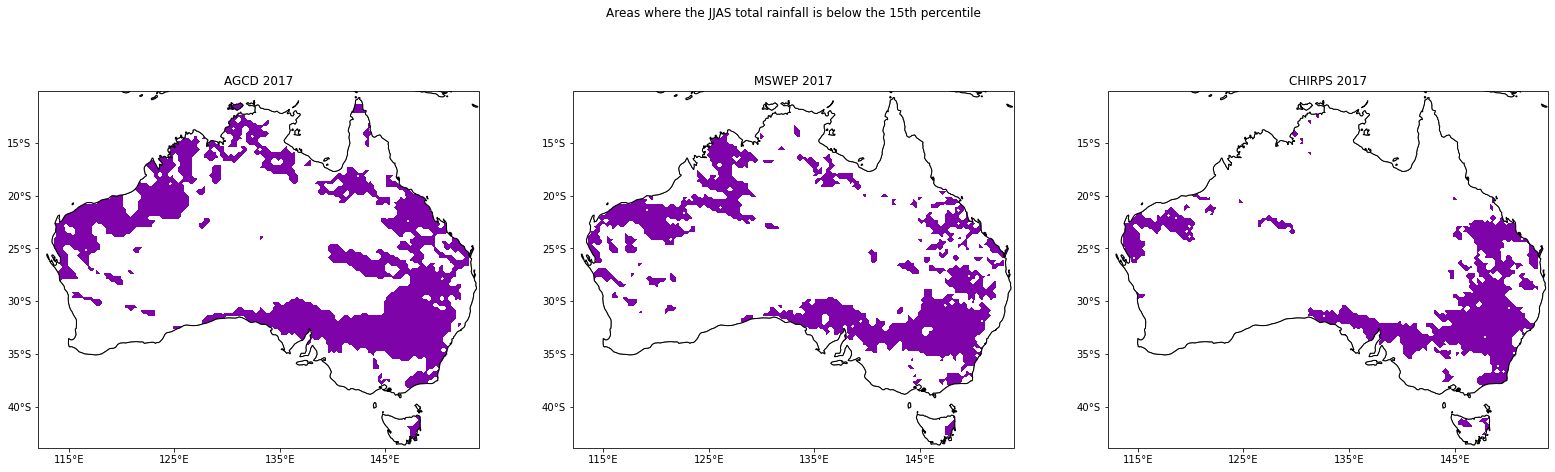

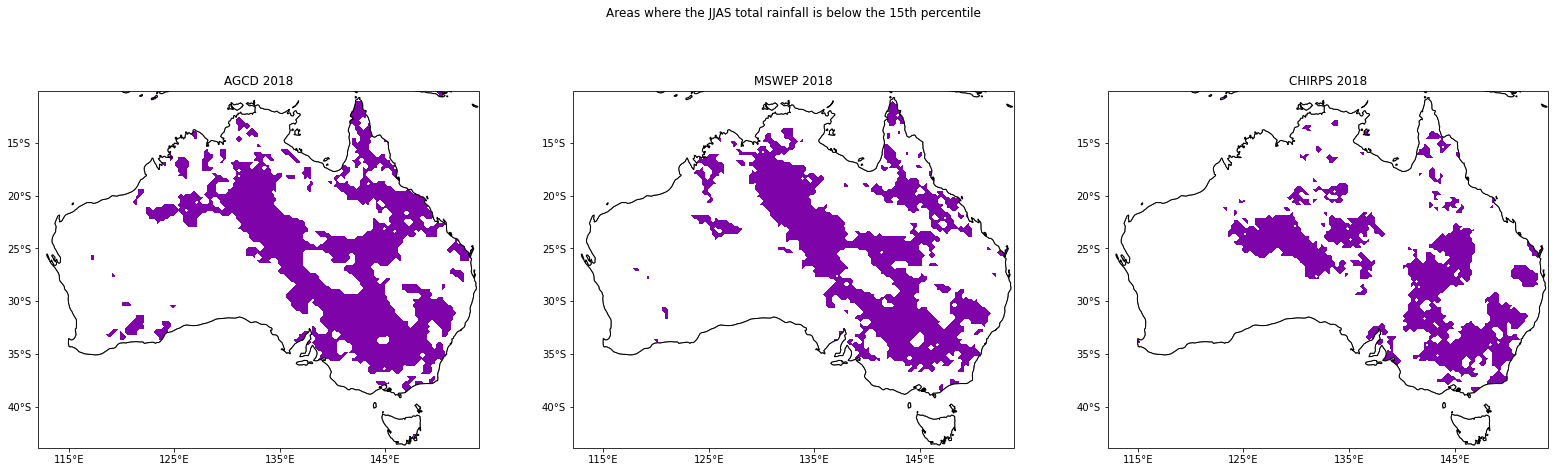

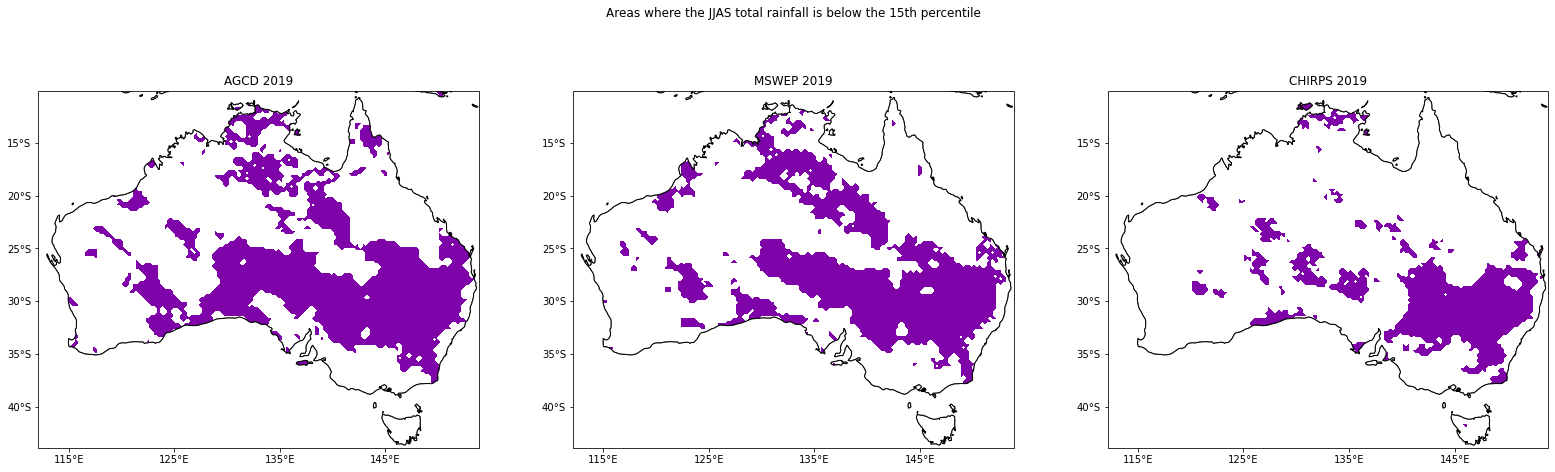

In [10]:
for year in [2017, 2018, 2019]:
    out_dir = 'figures/drought_2017to2020/drought_focusReg/'
    levels = [0.49999999, 0.6, 0.7, 0.8, 0.9, 1, 1.1] #np.linspace(0.5, 1, 6)
    main_title = 'Areas where the JJAS total rainfall is below the ' + str(perc) + 'th percentile'
    out_figname = 'areas_JJAStot_below_' + str(perc) + 'p_' + str(year) + '.png'
    # cbar_label = 'Mean proportion of time in drought during JJAS'

    cmap = 'plasma'

    levels = [0, 1, 2]

    da_byyear = da_lt_xp_mask.sel(year = year)
    ds_list = [da_byyear[0,:,:], da_byyear[1,:,:], da_byyear[2,:,:]] 
    draw_spatial_plot_3panels(ds_list = ds_list, cmap = cmap, levels = levels, subplot_title = [d + ' ' + str(year) for d in data_names], main_title = main_title, 
                                  out_dir = out_dir, out_figname = out_figname, add_cbar = False) #, cbar_label = cbar_label)

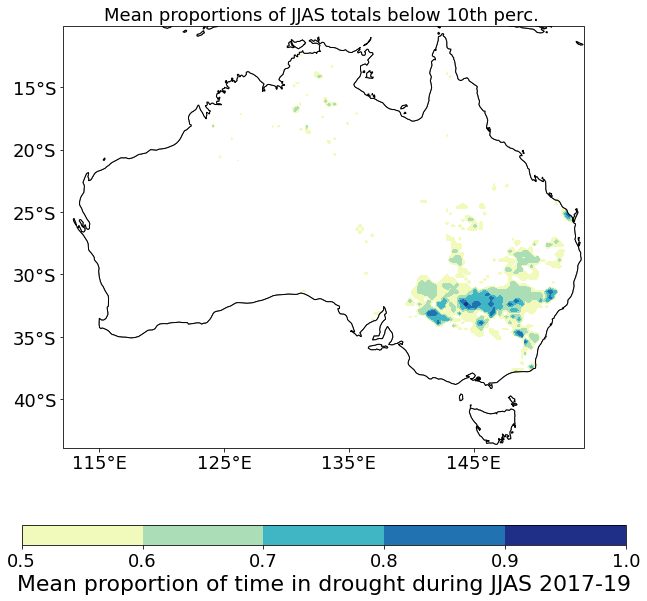

In [7]:
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = np.linspace(0.5, 1, 6)
main_title = 'Mean proportions of JJAS totals below ' + str(perc) + 'th perc. '
out_figname = 'mean_' + str(perc) + 'th_perc_precip_prop_dry_JJAStot_2017to19_gt_pt5.png'
cbar_label = 'Mean proportion of time in drought during JJAS 2017-19'

da_prop = da_lt_xp_mask.sum('year')/3
# da_prop = da_prop.where(da_prop >= 0.5)
da_prop_mean = da_prop.mean('data')

da_plot = da_prop_mean.where(da_prop_mean >=0.5)

draw_spatial_plot(ds = da_prop_mean, cmap = 'YlGnBu', levels = levels, main_title = main_title,
                  out_dir = out_dir, out_figname = out_figname, add_cbar = True, cbar_label = cbar_label)


### Applying percentile thresholds on annual total

In [3]:
%who

add_cyclic_point	 agcd_info	 alldata_dict	 awra_info	 ccrs	 cfeature	 chirps_info	 cticker	 draw_spatial_plot	 
draw_spatial_plot_12panels	 draw_spatial_plot_3panels	 draw_spatial_plot_addcontours	 get_da	 gleam_info	 glob	 mswep_info	 np	 pd	 
pickle	 plt	 regrid_all_from_list	 save_monthly_data	 sys	 xe	 xr	 


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import matplotlib.pyplot as plt
import pickle

%run -i drought_2017to2019/dataInfo_and_functions.py

In [6]:
perc = 15

data_dir_P = '/g/data/w97/ad9701/drought_2017to2020/precip_data/drght_' + str(perc) + 'th_perc_baseline_198101_202005_yearly/'
# data_dir_PminusPET = '/g/data/w97/ad9701/drought_2017to2020/PminusPET/drght_20th_perc_baseline_198101_202005/'

year_slice = slice(2017, 2019)

data_names = ['AGCD', 'MSWEP', 'CHIRPS'] #, 'AWRA', 'GLEAM']
data_dir = dict(zip(data_names,
                    [data_dir_P, data_dir_P, data_dir_P])) #, data_dir_PminusPET, data_dir_PminusPET]))

# lists to store the count of the number of months during which the drought existed
data_list = []
data_list_byyear = []
data_names_lower = [d.lower() for d in data_names]
for d in data_names_lower:
    
    fname = d + '_yearly_precip_lt_' + str(perc) + 'th_perc.nc'
    
    data_type = (data_dir[d.upper()].split('/')[-3]).split('_')[0]
    if data_type == 'precip':
        vname = alldata_dict[d]['varname']
    elif data_type == 'PminusPET':
        vname = 'PminusPET'
    
    in_file = data_dir[d.upper()] + fname
    ds = xr.open_dataset(in_file)
    da_temp = ds[vname].sel(year = year_slice)
    data_list.append(da_temp)
    
data_list_regrid = regrid_all_from_list(data_list)
da_lt_xp = xr.concat(data_list_regrid, dim = "data").assign_coords({'data': data_names})

ds_mask = xr.open_dataset('/g/data/w97/ad9701/drought_2017to2020/PminusPET/gleam_land_mask.nc')
da_mask = ds_mask['land_mask']

da_lt_xp_mask = xr.where(~np.isnan(da_lt_xp), 1, np.nan)*da_mask

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


In [7]:
# save

out_dir = '/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/'

da_mean = da_lt_xp_mask.sum('year').mean('data').rename('count').drop('quantile').assign_attrs({'description': 'Mean count of years. 2017-19 annual rain < ' + str(perc) + 'th percentile. Based on 3 precip datasets'})
da_byyear = da_lt_xp_mask.mean('data').rename('count').drop('quantile').assign_attrs({'description': '2017-19 annual rain < ' + str(perc) + 'th percentile. Based on 3 precip datasets'})

with open(out_dir + 'annual_rain_below_' + str(perc) + 'perc.pickle', 'wb') as handle:
    pickle.dump(da_mean, handle)
with open(out_dir + 'annual_rain_byyear_below_' + str(perc) + 'perc.pickle', 'wb') as handle:
    pickle.dump(da_byyear, handle)

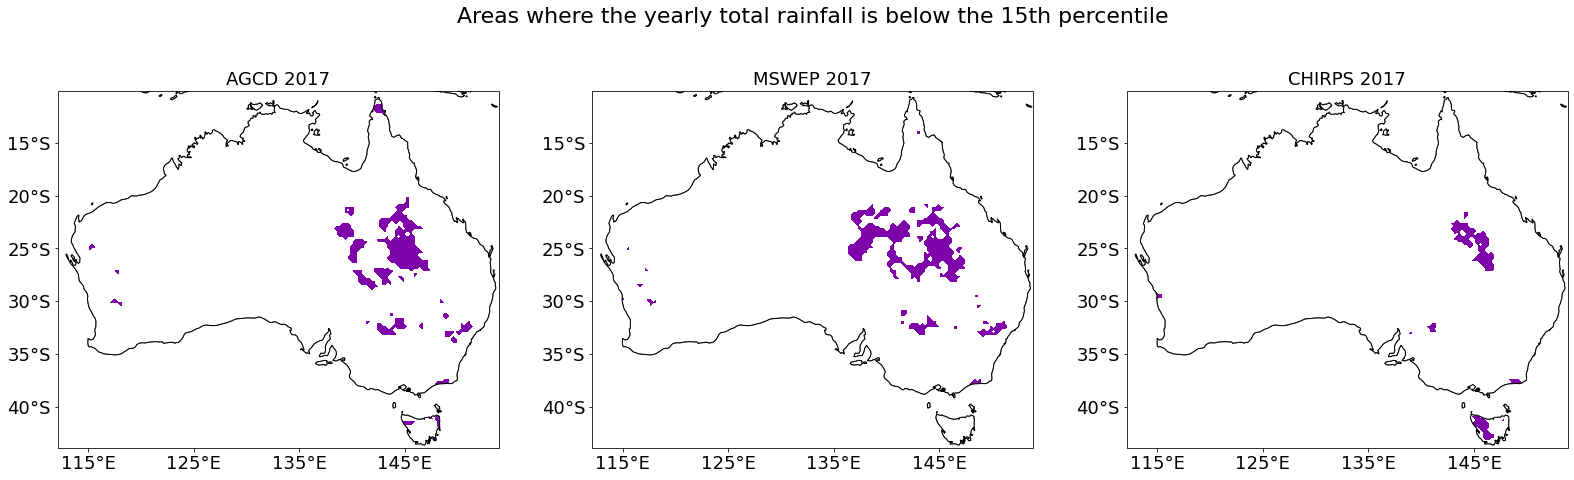

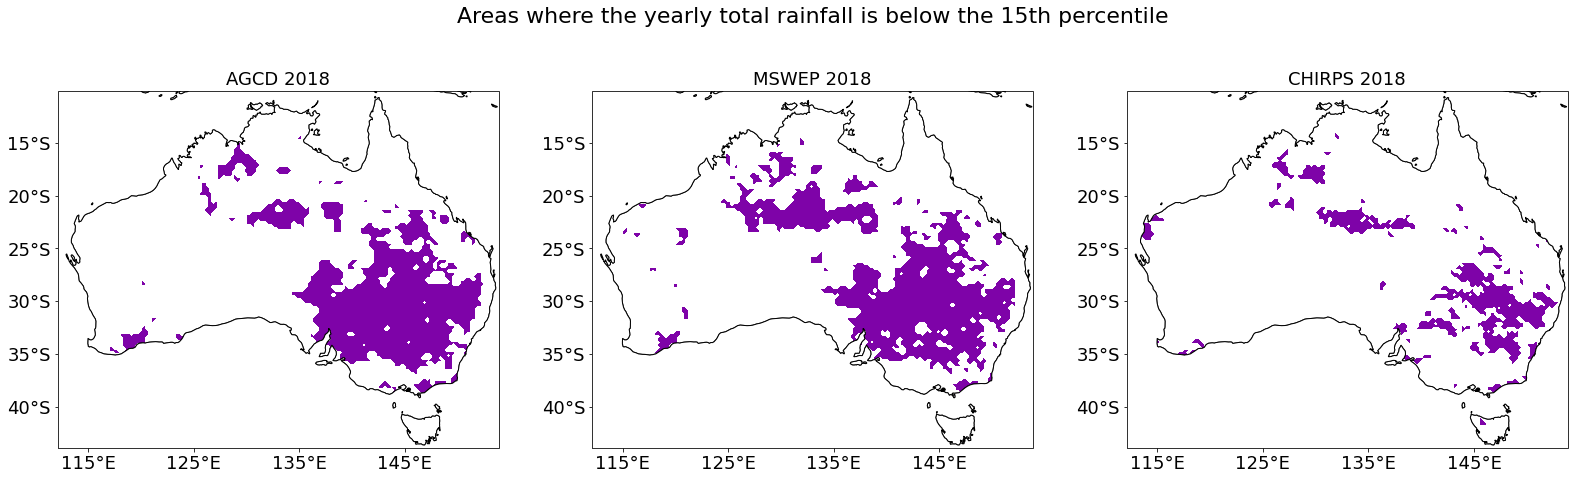

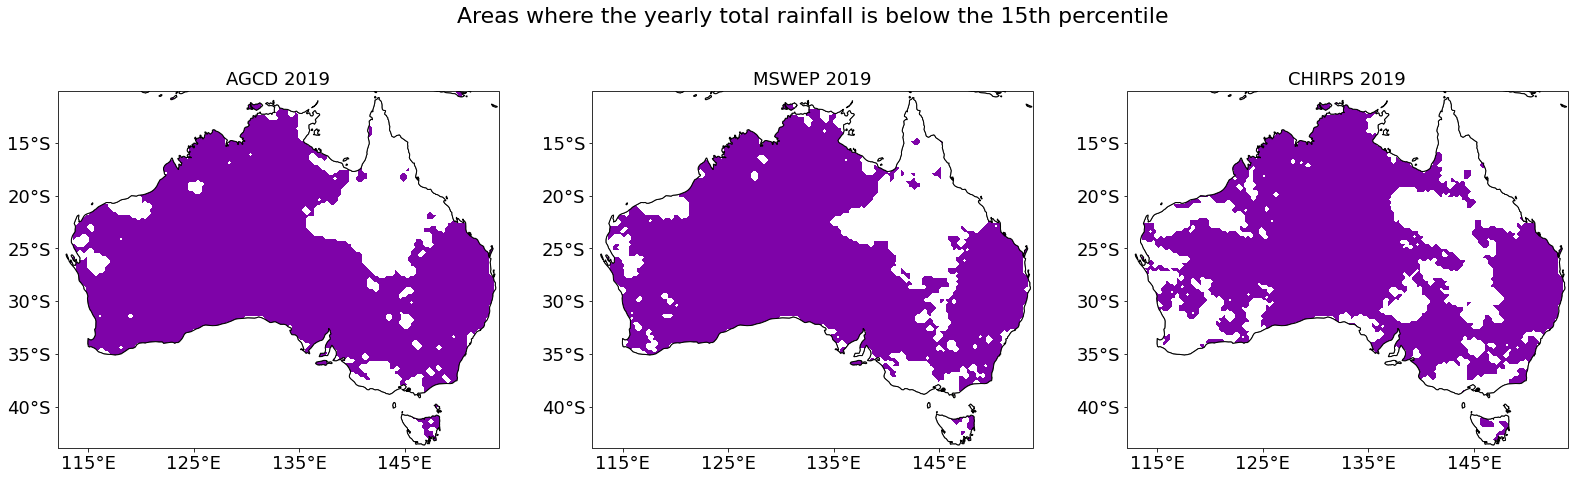

In [5]:
for year in [2017, 2018, 2019]:
    out_dir = 'figures/drought_2017to2020/drought_focusReg/'
    levels = [0.49999999, 0.6, 0.7, 0.8, 0.9, 1, 1.1] #np.linspace(0.5, 1, 6)
    main_title = 'Areas where the yearly total rainfall is below the ' + str(perc) + 'th percentile'
    out_figname = 'areas_yeartot_below_' + str(perc) + 'p_' + str(year) + '.png'
    # cbar_label = 'Mean proportion of time in drought during JJAS'

    cmap = 'plasma'

    levels = [0, 1, 2]

    da_byyear = da_lt_xp_mask.sel(year = year)
    ds_list = [da_byyear[0,:,:], da_byyear[1,:,:], da_byyear[2,:,:]] 
    draw_spatial_plot_3panels(ds_list = ds_list, cmap = cmap, levels = levels, subplot_title = [d + ' ' + str(year) for d in data_names], main_title = main_title, 
                                  out_dir = out_dir, out_figname = out_figname, add_cbar = False) #, cbar_label = cbar_label)

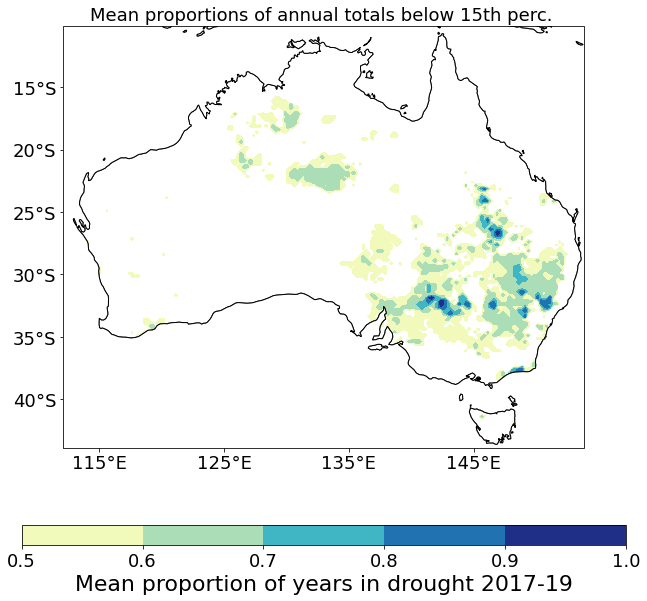

In [6]:
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = np.linspace(0.5, 1, 6)
main_title = 'Mean proportions of annual totals below ' + str(perc) + 'th perc. '
out_figname = 'mean_' + str(perc) + 'th_perc_precip_prop_dry_yeartot_2017to19_gt_pt5.png'
cbar_label = 'Mean proportion of years in drought 2017-19'

da_prop = da_lt_xp_mask.sum('year')/3
# da_prop = da_prop.where(da_prop >= 0.5)
da_prop_mean = da_prop.mean('data')

da_plot = da_prop_mean.where(da_prop_mean >=0.5)

draw_spatial_plot(ds = da_prop_mean, cmap = 'YlGnBu', levels = levels, main_title = main_title,
                  out_dir = out_dir, out_figname = out_figname, add_cbar = True, cbar_label = cbar_label)

### Applying percentiles on annual and JJAS soil moisture

In [19]:
%who

LATITUDE_FORMATTER	 LONGITUDE_FORMATTER	 add_cyclic_point	 agcd_info	 alldata_dict	 awra_info	 cbar_label	 ccrs	 cfeature	 
chirps_info	 cmap	 cticker	 d	 da_byyear	 da_lt_xp	 da_lt_xp_mask	 da_mean	 da_plot	 
da_prop	 da_prop_mean	 da_temp	 data_dir	 data_list	 data_list_byyear	 data_list_regrid	 data_names	 data_names_lower	 
data_type	 draw_spatial_plot	 draw_spatial_plot_12panels	 draw_spatial_plot_3panels	 draw_spatial_plot_addcontours	 draw_spatial_plot_addsh	 ds	 ds_list	 esacci_info	 
fname	 get_da	 get_da_simple	 gleam_info	 glob	 gpd	 handle	 in_file	 input_dir	 
levels	 main_title	 mswep_info	 mticker	 np	 out_dir	 out_figname	 pd	 perc	 
pickle	 plt	 regrid_all_from_list	 save_monthly_data	 save_monthly_data_byyear	 sys	 vname	 xe	 xr	 
year_slice	 years	 


In [20]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import matplotlib.pyplot as plt
import pickle

%run -i drought_2017to2019/dataInfo_and_functions.py

In [40]:
perc = 10

input_dir = '/g/data/w97/ad9701/drought_2017to2020/sm_data/drght_' + str(perc) + 'th_perc_baseline_198101_202005_JJAS/'

year_slice = slice(2017, 2019)

data_names = ['ESACCI'] #, 'AWRA', 'GLEAM']
data_dir = dict(zip(data_names,
                    [input_dir])) #, data_dir_PminusPET, data_dir_PminusPET]))

# lists to store the count of the number of months during which the drought existed
data_list = []
data_list_byyear = []
data_names_lower = [d.lower() for d in data_names]
for d in data_names_lower:
    
    fname = d + '_JJAS_lt_' + str(perc) + 'th_perc.nc'
    
    data_type = (data_dir[d.upper()].split('/')[-3]).split('_')[0]
    if (data_type == 'precip') | (data_type == 'sm'):
        vname = alldata_dict[d]['varname']
    elif data_type == 'PminusPET':
        vname = 'PminusPET'
    
    in_file = data_dir[d.upper()] + fname
    ds = xr.open_dataset(in_file)
    da_temp = ds[vname].sel(year = year_slice)
    data_list.append(da_temp)
    
data_list_regrid = regrid_all_from_list(data_list)
da_lt_xp = xr.concat(data_list_regrid, dim = "data").assign_coords({'data': data_names})

da_lt_xp_mask = xr.where(~np.isnan(da_lt_xp), 1, np.nan)

In [22]:
# save

out_dir = '/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/'

da_mean = da_lt_xp_mask.sum('year').mean('data').rename('count').drop('quantile').assign_attrs({'description': 'Count of 2017-19 JJAS season SM < ' + str(perc) + 'th percentile'})
da_byyear = da_lt_xp_mask.mean('data').rename('count').drop('quantile').assign_attrs({'description': 'JJAS season SM < ' + str(perc) + 'th percentile'})

with open(out_dir + 'JJASseas_soil_moisture_' + str(perc) + 'perc.pickle', 'wb') as handle:
    pickle.dump(da_mean, handle)
with open(out_dir + 'JJASseas_soil_moisture_byyear_' + str(perc) + 'perc.pickle', 'wb') as handle:
    pickle.dump(da_byyear, handle)

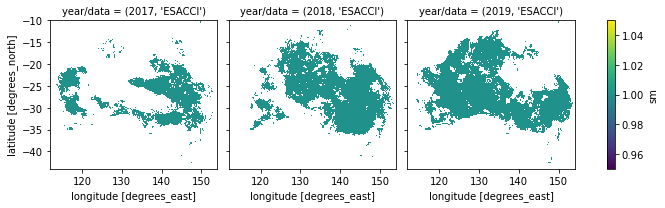

In [23]:
da_lt_xp_mask.stack({'year/data':['year', 'data']}).plot(col = 'year/data')

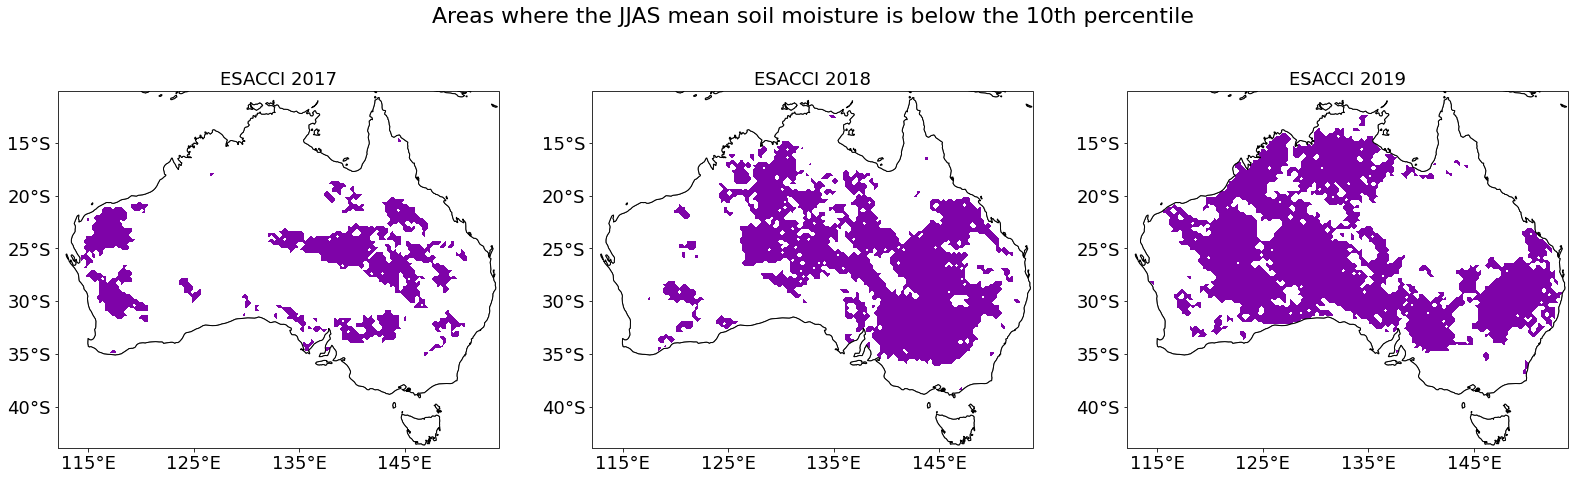

In [41]:
years = [2017, 2018, 2019]
d = data_names[0] # only one dataset
    
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = [0.49999999, 0.6, 0.7, 0.8, 0.9, 1, 1.1] #np.linspace(0.5, 1, 6)
main_title = 'Areas where the JJAS mean soil moisture is below the ' + str(perc) + 'th percentile'
out_figname = 'areas_JJASmean_below_' + str(perc) + 'p_' + d + '.png'
# cbar_label = 'Mean proportion of time in drought during JJAS'

cmap = 'plasma'

levels = [0, 1, 2]

da_byyear = da_lt_xp_mask
ds_list = [da_byyear.sel(year = i, data = d) for i in years] 
draw_spatial_plot_3panels(ds_list = ds_list, cmap = cmap, levels = levels, subplot_title = [d + ' ' + str(i) for d in data_names for i in years], main_title = main_title, 
                              out_dir = out_dir, out_figname = out_figname, add_cbar = False) #, cbar_label = cbar_label)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


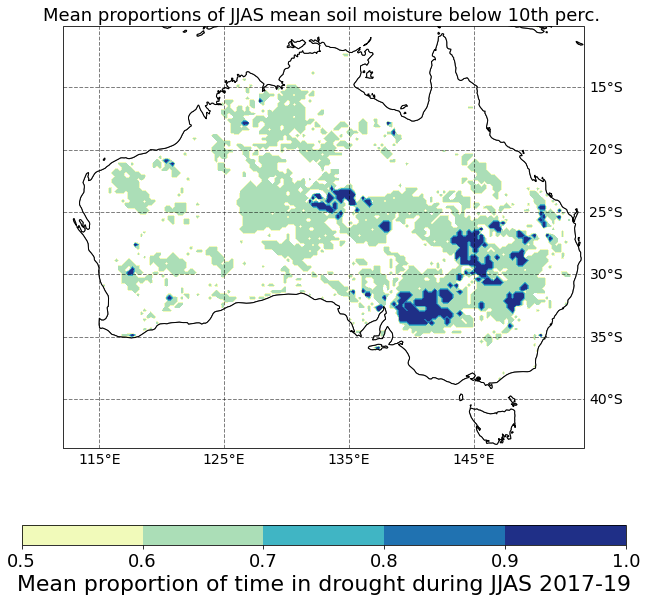

In [42]:
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = np.linspace(0.5, 1, 6)
main_title = 'Mean proportions of JJAS mean soil moisture below ' + str(perc) + 'th perc. '
out_figname = 'mean_' + str(perc) + 'th_perc_precip_prop_dry_JJASmean_SM_2017to19_gt_pt5.png'
cbar_label = 'Mean proportion of time in drought during JJAS 2017-19'

da_prop = da_lt_xp_mask.sum('year')/3
# da_prop = da_prop.where(da_prop >= 0.5)
da_prop_mean = da_prop.mean('data')

da_plot = da_prop_mean.where(da_prop_mean >=0.5)

draw_spatial_plot(ds = da_prop_mean, cmap = 'YlGnBu', levels = levels, main_title = main_title,
                  out_dir = out_dir, out_figname = out_figname, add_cbar = True, cbar_label = cbar_label)

### Applying percentile thresholds on annual mean sm

In [3]:
%who

add_cyclic_point	 agcd_info	 alldata_dict	 awra_info	 ccrs	 cfeature	 chirps_info	 cticker	 draw_spatial_plot	 
draw_spatial_plot_12panels	 draw_spatial_plot_3panels	 draw_spatial_plot_addcontours	 get_da	 gleam_info	 glob	 mswep_info	 np	 pd	 
pickle	 plt	 regrid_all_from_list	 save_monthly_data	 sys	 xe	 xr	 


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import matplotlib.pyplot as plt
import pickle

%run -i drought_2017to2019/dataInfo_and_functions.py

In [46]:
perc = 15

data_dir_sm = '/g/data/w97/ad9701/drought_2017to2020/sm_data/drght_' + str(perc) + 'th_perc_baseline_198101_202005_yearly/'
# data_dir_PminusPET = '/g/data/w97/ad9701/drought_2017to2020/PminusPET/drght_20th_perc_baseline_198101_202005/'

year_slice = slice(2017, 2019)

data_names = ['ESACCI'] #, 'AWRA', 'GLEAM']
data_dir = dict(zip(data_names,
                    [data_dir_sm])) #, data_dir_PminusPET, data_dir_PminusPET]))

# lists to store the count of the number of months during which the drought existed
data_list = []
data_list_byyear = []
data_names_lower = [d.lower() for d in data_names]
for d in data_names_lower:
    
    fname = d + '_yearly_lt_' + str(perc) + 'th_perc.nc'
    
    data_type = (data_dir[d.upper()].split('/')[-3]).split('_')[0]
    if (data_type == 'precip') | (data_type == 'sm'):
        vname = alldata_dict[d]['varname']
    elif data_type == 'PminusPET':
        vname = 'PminusPET'
    
    in_file = data_dir[d.upper()] + fname
    ds = xr.open_dataset(in_file)
    da_temp = ds[vname].sel(year = year_slice)
    data_list.append(da_temp)
    
data_list_regrid = regrid_all_from_list(data_list)
da_lt_xp = xr.concat(data_list_regrid, dim = "data").assign_coords({'data': data_names})

da_lt_xp_mask = xr.where(~np.isnan(da_lt_xp), 1, np.nan)

In [33]:
# save

out_dir = '/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/'

da_mean = da_lt_xp_mask.sum('year').mean('data').rename('count').drop('quantile').assign_attrs({'description': 'Count of years. 2017-19 annual soil moisture < ' + str(perc) + 'th percentile. Based on ESACCI dataset'})
da_byyear = da_lt_xp_mask.mean('data').rename('count').drop('quantile').assign_attrs({'description': '2017-19 annual soil moisture < ' + str(perc) + 'th percentile. Based on ESACCI dataset'})

with open(out_dir + 'annual_soil_moisture_below_' + str(perc) + 'perc.pickle', 'wb') as handle:
    pickle.dump(da_mean, handle)
with open(out_dir + 'annual_soil_moisture_byyear_below_' + str(perc) + 'perc.pickle', 'wb') as handle:
    pickle.dump(da_byyear, handle)

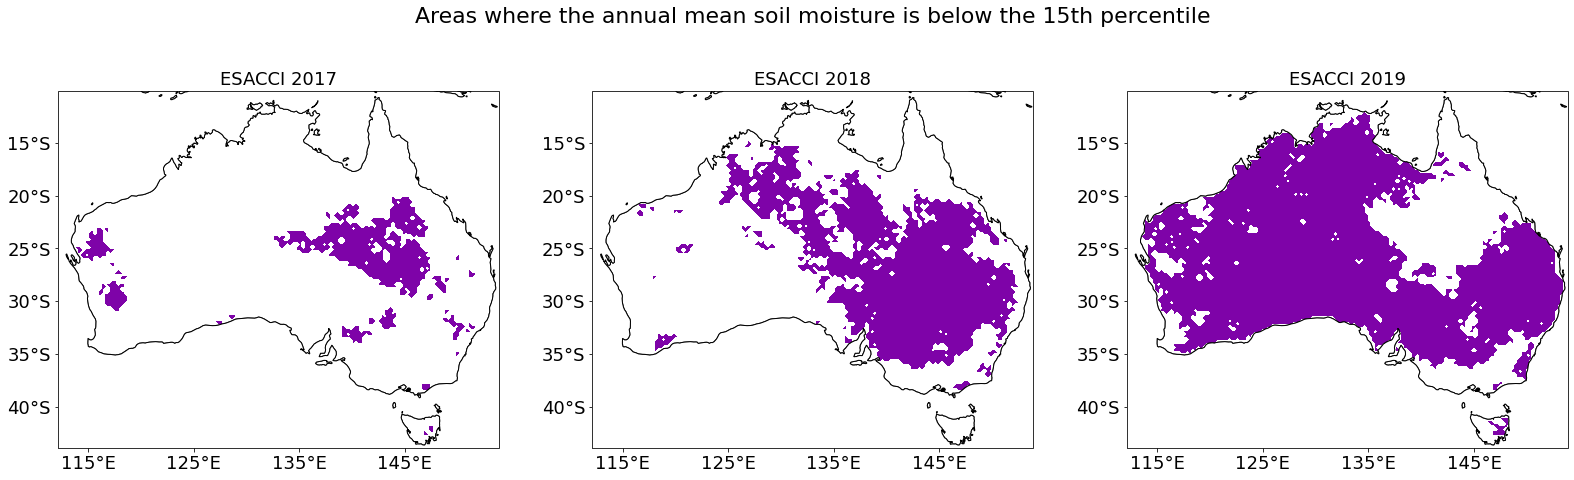

In [47]:
years = [2017, 2018, 2019]
d = data_names[0] # only one dataset
    
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = [0.49999999, 0.6, 0.7, 0.8, 0.9, 1, 1.1] #np.linspace(0.5, 1, 6)
main_title = 'Areas where the annual mean soil moisture is below the ' + str(perc) + 'th percentile'
out_figname = 'areas_annual_mean_below_' + str(perc) + 'p_' + d + '.png'
# cbar_label = 'Mean proportion of time in drought during JJAS'

cmap = 'plasma'

levels = [0, 1, 2]

da_byyear = da_lt_xp_mask
ds_list = [da_byyear.sel(year = i, data = d) for i in years] 
draw_spatial_plot_3panels(ds_list = ds_list, cmap = cmap, levels = levels, subplot_title = [d + ' ' + str(i) for d in data_names for i in years], main_title = main_title, 
                              out_dir = out_dir, out_figname = out_figname, add_cbar = False) #, cbar_label = cbar_label)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


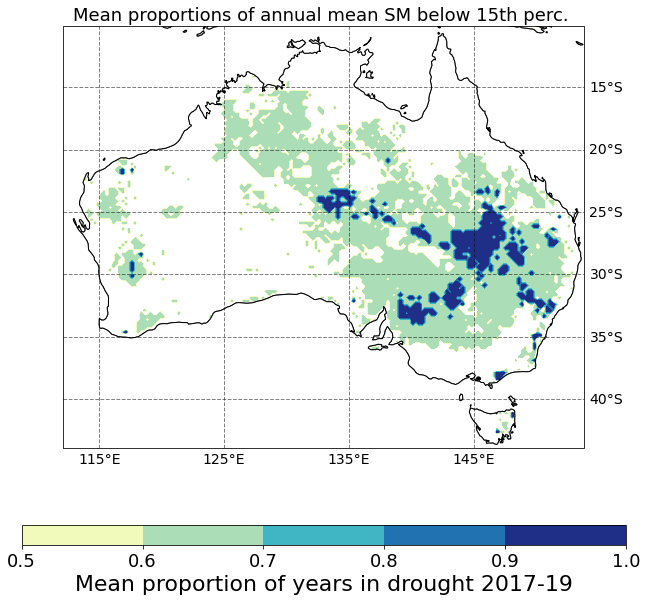

In [48]:
out_dir = 'figures/drought_2017to2020/drought_focusReg/'
levels = np.linspace(0.5, 1, 6)
main_title = 'Mean proportions of annual mean SM below ' + str(perc) + 'th perc. '
out_figname = 'mean_' + str(perc) + 'th_perc_SM_prop_dry_yeartot_2017to19_gt_pt5.png'
cbar_label = 'Mean proportion of years in drought 2017-19'

da_prop = da_lt_xp_mask.sum('year')/3
# da_prop = da_prop.where(da_prop >= 0.5)
da_prop_mean = da_prop.mean('data')

da_plot = da_prop_mean.where(da_prop_mean >=0.5)

draw_spatial_plot(ds = da_prop_mean, cmap = 'YlGnBu', levels = levels, main_title = main_title,
                  out_dir = out_dir, out_figname = out_figname, add_cbar = True, cbar_label = cbar_label)

### First pass area definition for the drought study

In [5]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import matplotlib.pyplot as plt
import pickle

%run -i drought_2017to2019/dataInfo_and_functions.py

In [6]:
import matplotlib.pyplot as plt

TINY_SIZE = 14
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 22

plt.rc('font', size=TINY_SIZE)           # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=TINY_SIZE)     # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title